## Compute EOFs of SST data
This is an example of how to do Homework 5 EOF Analysis of Monthly SST <br/>
Dennis L. Hartmann  January 13, 2023  for ATMS 552

As of Jan. 17, 2023 I have not figured out an efficient way to removed the global mean from each monthly map prior to analysis <br/>
In consequence of this, when you do the global SST for a long period like since 1900, global warming is part of the second EOF. <br/>
To better study the natural internal variability, I would like to get rid of the global mean trend.


In [570]:
### First select needed software
#%reset
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf
from scipy.io import loadmat
from scipy.interpolate import griddata
import scipy.signal as sig
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import pandas as pd
import netCDF4 as nc
import warnings
from cartopy import config
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


## Some information on the data
SST data are montnly, and can be downloaded from https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.ersst.v5.html <br/>
SST starts in 1854 and goes to present,  In Jan 2023 I downloaded data complete for 2022, <br/>



iyr1 =  552 , iyr2 =  2028
lonp  (181,)
lonp[-1]  360.0
lonp  (181,)
shape sst  (2028, 89, 180)
(89, 180)
sstmp  (89, 181)
max sst nan
xx  (89,)
sst clipped shape  (2028, 89, 180)


/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings =

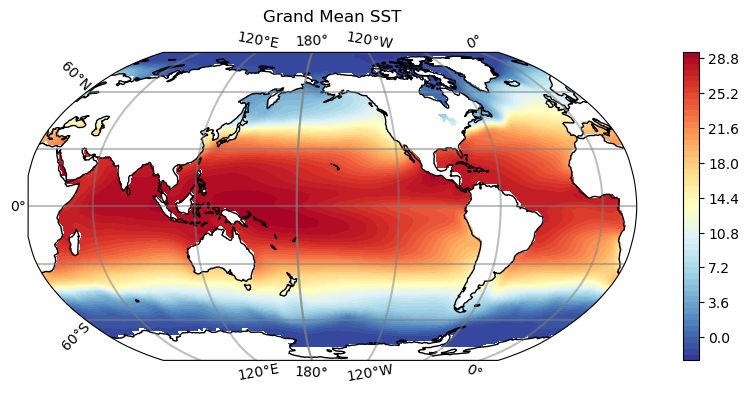

sst type  <class 'xarray.core.dataarray.DataArray'>


In [571]:
### Next open data set and read it in

# SST fields
filesst = 'data/sst.mnmean.nc'
# set years to begin and end for climatology
yrbeg = 1900
yrend = 2022
#set the years for eof analysis
yra = yrbeg
yrb = yrend
cent_lon = -160.   # central longitude for Robinson maps

rem_trend = False
rem_globmean = False
rem_trend = True
rem_globmean = False

# set eof window

# Big Pacific
lat1=45.
lat2=-45.
lon1=120.
lon2=290.

# Northern Midlatitudes
lat1=60.
lat2=30.
lon1=0.
lon2=360.

# Global Tropics
lat1=10.
lat2=-10.
lon1=0.
lon2=360.

# Traditional PDO region
lat1=65.
lat2=20.
lon1=120.
lon2=260.

# Atlantic N-S region
lat1=70.
lat2=-65.
lon1=300.
lon2=360.

#  Global domain
lat1=88.
lat2=-88.
lon1=0.
lon2=360.

iyr1 = (yrbeg-1854)*12
iyr2 = (yrend - 1854 + 1)*12
print('iyr1 = ',iyr1,', iyr2 = ',iyr2)

# open  using netCDF4 and xarray
with warnings.catch_warnings(record=True):  # this does not seem to suppress warnings as advertized
    ds = nc.Dataset(filesst)
    #print(ds)
    # open using xarray
    ds_disk = xr.open_dataset(filesst)  # this worked
    ds_disk   # this tells you what is in the data set.  Gives time in year-mn-da
    sst = ds_disk.sst   # not here prcp is actually sst
    lon = ds_disk.lon
    # extend longitude array
    lonp = np.empty(len(lon)+1)
    lonp[0:len(lon)] = lon
    lonp[len(lon)]= lon[len(lon)-1]+lon[1]-lon[0]
    print('lonp ',np.shape(lonp))
    print('lonp[-1] ',lonp[-1])
    print('lonp ',np.shape(lonp))
    #  
    lat = ds_disk.lat
    print('shape sst ',np.shape(sst))
    sstm = np.nanmean(sst,0)
    print(np.shape(sstm))
    # Here we are adding cyclic continuity to SST, so it plots without gaps
    sstmp = np.empty([len(lat),len(lon)+1])
    print('sstmp ',np.shape(sstmp))
    sstmp[:,0:len(lon)]= sstm
    sstmp[:,len(lon+1)]= sstm[:,0]
    xx = sstmp[:,0]
    print('max sst',np.max(sstmp))
    print('xx ',np.shape(xx))   #  This is likely NaN
# clip out years I want to consider
sst1 = sst[iyr1:iyr2,:,:]
print('sst clipped shape ',np.shape(sst))

# begin Copied chunk for example of formatting plots * * * * * 
#ax = plt.axes(projection=ccrs.Mercator())
#ax.coastlines()

#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
#gl.xlabels_top = False
#gl.ylabels_left = False
#gl.xlines = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'size': 15, 'color': 'gray'}
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

#plt.show() 
# end copied chunk. * * * * * * * * * * * * * 

# plot the grand mean
# let's try to plot a monthly mean
#col_map = 'coolwarm'
col_mapc = 'RdYlBu_r'
col_mapr = 'RdYlBu_r'
plt.figure(figsize=(12, 4), dpi=100)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))
#  I like a central longitude of 150W for showing the ocean the best
#  It puts the Pacific in the center and the cut at a longitude of maximum in continentality
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
plt.contourf(lonp, lat, sstmp, 60, cmap=col_mapc,
             transform=ccrs.PlateCarree())
plt.title('Grand Mean SST')
ax.coastlines()
plt.grid()
plt.colorbar()
#plt.colorbar(location='bottom')
plt.show()
print('sst type ',type(sst))

## next let's remove the average annual cycle


In [572]:

# OK, not lets try to take the annual cycle out of the sst
sstx = xr.DataArray.to_numpy(sst1)  # transition to numpy space
latx=len(lat) 
lonx=len(lon)
print('latx ',type(latx))
print('sst shape ',np.shape(sstx))
print('type sst ',type(sstx))
sts = np.shape(sstx)
yrmx = int(sts[0]/12)
print('sts[0] = ',sts[0],'yrmx = ',yrmx)

# Now remove annual cycle from prcp
sstx = np.reshape(sstx,(yrmx,12,latx,lonx))
print('sstx shape ',np.shape(sstx))
sstm = np.nanmean(sstx,0)
print('sstm ',np.shape(sstm))
sstmx = np.max(sstm)
print('sstmx ',sstmx)



latx  <class 'int'>
sst shape  (1476, 89, 180)
type sst  <class 'numpy.ndarray'>
sts[0] =  1476 yrmx =  123
sstx shape  (123, 12, 89, 180)
sstm  (12, 89, 180)
sstmx  nan


/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


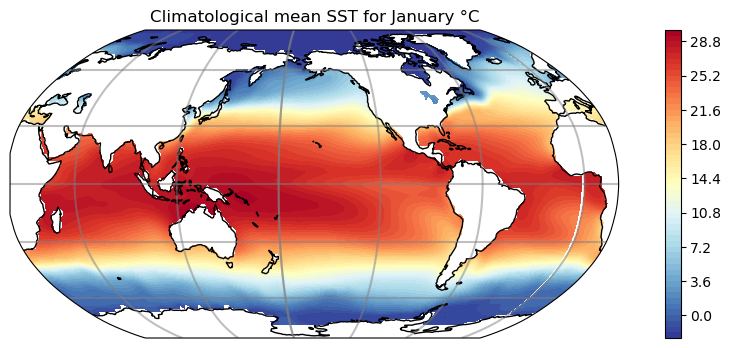

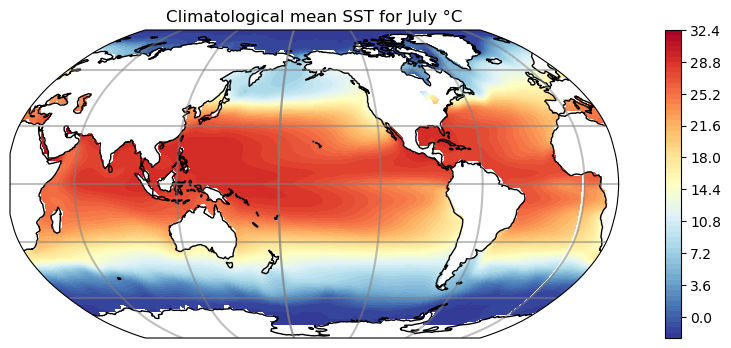

In [573]:
# let's try to plot a monthly mean
plt.figure(figsize=(12, 4), dpi=100)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))

plt.contourf(lon, lat, sstm[0,:,:], 60, cmap = col_mapc,
             transform=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
ax.coastlines()
plt.colorbar()

plt.title('Climatological mean SST for January \N{DEGREE SIGN}C')
#plt.colorbar(location='bottom')
plt.show()

plt.figure(figsize=(12, 4), dpi=100)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))

plt.contourf(lon, lat, sstm[6,:,:], 60, cmap = col_mapc,
             transform=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
ax.coastlines()
plt.colorbar()

plt.title('Climatological mean SST for July \N{DEGREE SIGN}C')
#plt.colorbar(location='bottom')
plt.show()

rem_ann = True
if rem_ann is True:
    # subtract mean from each month
    for i in range(0,yrmx):
        sstx[i,:,:,:] = sstx[i,:,:,:]-sstm


## Now we have selected the time period and removed the annual cycle for that time period
Variables in hand are lat, lon, sst(yrmx,12,89,180)  <br/>
With the seasonal cycle removed  <br/>
Next we'll want to pick a subset of months and region for which we will compute and plot EOFs  <br/>

size years (1476,) 1900-01-01 2022-12-31
lat_sh (89,)
shape ssta  (1476, 89, 180)
range(0, 89)


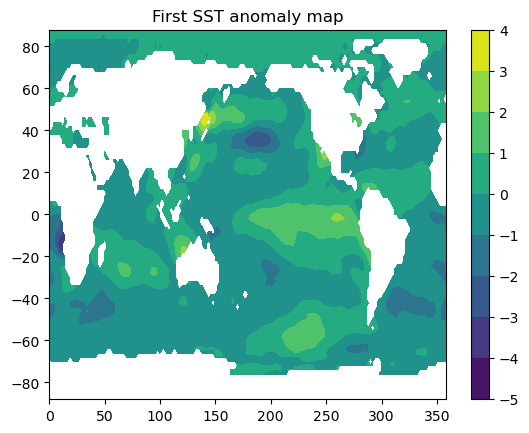

In [574]:
#  Specify the geographical boundaries and months we want to use
# let's experiment a bit with the xarray version
#sst  # this statement tells you what is in the structure sst 
#ssta = sst.sel(time=slice(1950-1-1, 2022-1-1),lon=slice(0., 90.),lat=slice(0., 89.))

yr1= str(yra)+'-01-01'
yr2= str(yrb)+'-12-31'
years = np.linspace(float(yra),float(yrb+1),num = (yrb-yra+1)*12)
print('size years',np.shape(years),yr1,yr2)

sst0 = sst.sel(time=slice(yr1, yr2),lat=slice(90., -90),lon=slice(0., 360.))

ssta = sst.sel(time=slice(yr1, yr2),lat=slice(lat1, lat2),lon=slice(lon1, lon2))
# here I think I am weighting the data array for sqrt(cosine(latitude) so area variance is used in EOF computation

lat_sh=ssta.lat
lon_sh=ssta.lon
print('lat_sh',np.shape(lat_sh))
cn = np.sqrt(np.cos(lat_sh*np.pi/180.))
#weights
#ssta_weighted = ssta.weighted(weights)
#type(ssta_weighted)
#print('ssta_weighted ',np.shape(ssta_weighted))
#sst0 = np.reshape(sst0,(mnx,latx,lonx))
print('shape ssta ',np.shape(ssta))
print(range(len(lat_sh)))

def globalmean(sst,cn,mnx,lat_sh):  # I have not finished or implemented removing the global mean from each month.
    for i in range(mnx):
        for j in range(len(lat_sh)):
            sst[i,j,:] = sst[i,j,:]*cn[j]  # times sqrt(cos(lat))
    gm = nanmean(sst,1)
    gm = nanmean(gm,1)
    return gm

if rem_globmean: 
    gm = globalmean(ssta,cn,mnx,lat_sh)
    print('gm = ',gm[0:12]) 
    
for i in range(len(lat_sh)):  # this loop weights ssta by our sqrt(cos(lat))
    ssta[:,i,:] = ssta[:,i,:]*cn[i]  # times sqrt(cos(lat))

plt_test = True
if plt_test:
    plt.figure()
    #xr.plot.contourf(ssta_weighted[0,:,:]) 
    plt.contourf(lon_sh,lat_sh,ssta[0,:,:]) 
    plt.title('First SST anomaly map')
    plt.colorbar()


# Before we do EOF Analysis, let's make a land mask using a topographic map
Must be an easier way of doing this

In [575]:
#  Ok, I have now a data set from which I have removed the annual cycle and I have windowed it down to a specific region
#  I think I need to get rid of the nan values over land before I can compute the SVD of this matrix

# read in a topographic data file that we are going to use as our mask for using SST data
filetopo = 'data/elev.0.5-deg.nc' # topographic data to use as a data mask for SST
ds = nc.Dataset(filetopo)
#print(ds)
topoi = ds.variables['data'][:]
latt = ds.variables['lat'][:]
lont  = ds.variables['lon'][:]
print('size topoi ',np.shape(topoi))
topot = np.float64(np.squeeze(np.float32(topoi)))
print('size topot ',np.shape(topot))
# next we need to interpolate the topo array to the sst coordinates
# make latlon 2-D grids for interpolation
latb, lonb  = np.meshgrid(lat,lon, indexing = 'ij')
lattb, lontb = np.meshgrid(latt,lont, indexing = 'ij')
latb = np.reshape(latb,len(lon)*len(lat))
lonb = np.reshape(lonb,len(lon)*len(lat))
lattb = np.reshape(lattb,len(lont)*len(latt))
lontb = np.reshape(lontb,len(lont)*len(latt))
topot = np.reshape(topot,len(lont)*len(latt))

topo = griddata((lattb,lontb),topot,(latb,lonb))
topo = np.reshape(topo,(len(lat),len(lon)))
print_topo = False
if print_topo:
    maxt = np.nanmax(np.abs(topo))
    print('matx ',maxt)
    contt= np.linspace(-maxt,maxt,60)
    plt.figure()
    plt.contourf(lon,lat,topo,levels=contt,cmap='RdYlBu_r')                  
    plt.colorbar()
    


size topoi  (1, 360, 720)
size topot  (360, 720)


## Arrange data in a form useful for EOF Analysis
We need an array that is 2-D with all the data points in one direction and all the months in another

shape topa  (89, 180)
matx  7562.5


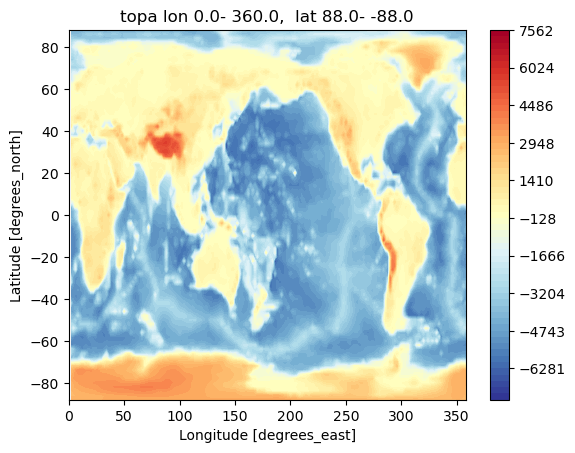

In [576]:
# we have from before an array "topo" that contains the topographic height, negative values are under the sea, positive values are land
#  We have our SST anomaly that is of dimension (time, lat, lon), and topo interpolated to the same (lat,lon) grid.
# sstx is windowed into a smaller region that we want to perform EOF Analysis upon
# let's window the topo map to the same window
# convert data sets to xarray
topog = xr.DataArray(topo, coords = [lat, lon], dims = ["latitude","longitude"])
latg = xr.DataArray(lat, coords = [lat], dims = ["latitude"])
long = xr.DataArray(lon, coords = [lon], dims = ["longitude"])
topa = topog.sel(latitude=slice(lat1, lat2),longitude=slice(lon1, lon2))
#lona = lon.sel(longitude=slice(lon1, lon2))
#lata = lat.sel(latitude=slice(lat1, lat2))
print('shape topa ',np.shape(topa))
plot_topa = True   # plot topography in our data window
if plot_topa:
    maxt = np.nanmax(np.abs(topa))
    print('matx ',maxt)
    contt= np.linspace(-maxt,maxt,60)
    plt.figure()
#    xr.plot.contourf(lona,lata,topa,levels=contt,cmap='RdYlBu_r')  
    xr.plot.contourf(topa,levels=contt,cmap='RdYlBu_r')  
    #plt.colorbar()
    plt.title('topa ' + 'lon ' + '%.1f' %lon1 + '- ' + '%.1f' %lon2 + ',  lat ''%.1f' %lat1 + '- ' + '%.1f' %lat2)


In [577]:
# now we have selected region and topography to match, let's remove the land from our data set
# try to remove all land areas from sstx
mnx = len(years)
print('mnx = ',mnx)

sstx = xr.DataArray.to_numpy(ssta)
topx = xr.DataArray.to_numpy(topa)
sstx[np.isnan(sstx)] = 0.0
mmax = np.max(sstx)
print('mmax ',mmax)
print(type(topx))
# make an array that is nan if topography is .0 and 1.0 if topography < 0.

topy = topx
topy[topy >= 0 ] = np.nan
topy[topy < 0] =1.0
plot_topy = False
if plot_topy:
    plt.figure()
    plt.contourf(topy)
print('topy shape ',np.shape(topy))
lattx, lontx = np.shape(topy)
print('lattx', lattx,', lontx ', lontx)
topy = np.reshape(topy,(lattx*lontx))
topz = topy[np.isfinite(topy)]
print('topy shape ',np.shape(topy))
print('topz shape ',np.shape(topz))
#ar_sz = int(np.shape(topz))
ar_sz = len(topz)
type(ar_sz)
sstz=np.zeros([mnx,ar_sz])

#  if you rerun this script without going back to the beginning it fails to find any non-nan values in ssty1

#mnxx = 2
sstx = np.reshape(sstx,(mnx,lattx*lontx))
ssty = np.zeros([lattx*lontx],dtype = float)
for im in range(mnx):
    ssty = np.multiply(np.squeeze(sstx[im,:]),topy)
    #ssty[im,:,:] = np.multiply(sstx[im,:,:],topy)
    ssty1 = ssty[np.isfinite(ssty)]
    #sstz_sz = np.shape(ssty)
    sstz[im,:] = ssty1
    #print('sst_sz ',sstz_sz)
print('sstx ',np.shape(sstx))
print('ssty ',np.shape(ssty))
print('sstz ',np.shape(sstz))
print('ssty1 ',np.shape(ssty1))
print('lattx*lontx ',lattx*lontx)



mnx =  1476
mmax  7.686826
<class 'numpy.ndarray'>
topy shape  (89, 180)
lattx 89 , lontx  180
topy shape  (16020,)
topz shape  (10529,)
sstx  (1476, 16020)
ssty  (16020,)
sstz  (1476, 10529)
ssty1  (10529,)
lattx*lontx  16020


In [578]:
# Ok, now I think we have an array sstz that is [months,space]  Where only land regions are kept
# First let's estimate the number of degrees of freedom in the sample by estimating a grand autocorrelation
def autocorr2(x,lags):
    '''manualy compute, non partial'''

    mean=np.nanmean(x)
    var=np.nanvar(x)
    if var == 0.0:
        var=1.0e-6
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    #corr=[ np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    return np.array(corr)
xcor = np.zeros([2])

nt, ns = np.shape(sstz)
print('nt',nt,'ns',ns)
type(ns)

lags = [0,1]
for i in range(ns):
    xx=np.squeeze(sstz[:,i])
    xcor1 = autocorr2(xx,lags)
    xcor = xcor + xcor1

print('xx',xx[0:4],xx[-4:])    
xcor = xcor/float(ns)
print('xcor ',xcor)
acorr = xcor[1]
dof_sst = mnx*(1. - acorr**2)/(1. + acorr**2)
print('DOF = ',dof_sst,',   DOF/mnx = ',dof_sst/mnx,',  mnx = ',mnx)
# extend longitude array
#lonp = np.empty(len(lon)+1)
#lonp[0:len(lon)] = lon
#lonp[len(lon)]= lon[len(lon)-1]+lon[1]-lon[0]
#print('lonp ',np.shape(lonp))
#print('lonp[-1] ',lonp[-1])
#print('lonp ',np.shape(lonp))

nt 1476 ns 10529
xx [0. 0. 0. 0.] [0. 0. 0. 0.]
xcor  [1.   0.74]
DOF =  429.8864667489266 ,   DOF/mnx =  0.2912509937323351 ,  mnx =  1476


## now we can attempt eof analysis
We have our SST array that is space times time in months
sstx contains this data


In [579]:
# check the shape again
print('sstz shape ',np.shape(sstz))
if rem_trend:
    sstz = sig.detrend(sstz,axis=0)   # remove trend
#if rem_globmean:
#    for i in range(0,lattx*lontx):
#        sstz[i,:]=sstz[i,:] - np.nanmean(sstz[i,:],1)

mmax = np.max(sstz)
print('mmax ',mmax)
u, s, vh = np.linalg.svd(sstz.T)
print('u shape',np.shape(u))


sstz shape  (1476, 10529)
mmax  7.100235733373578
u shape (10529, 10529)


u shape (10529, 10529)
vh shape (1476, 1476)
s shape (1476,)


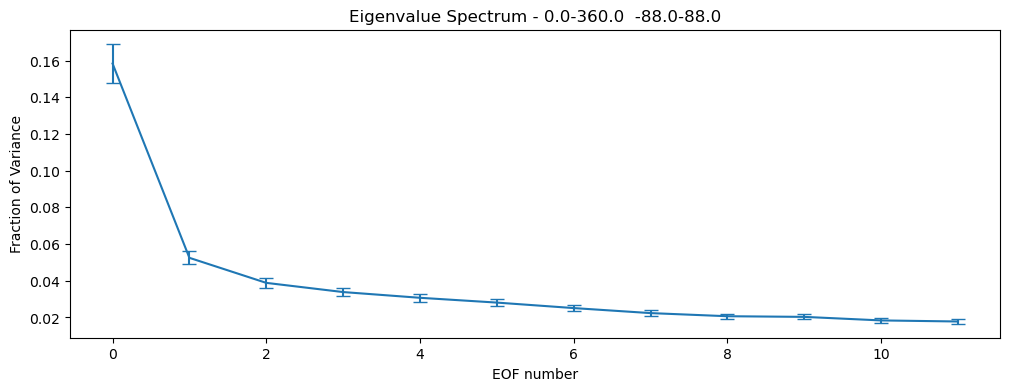

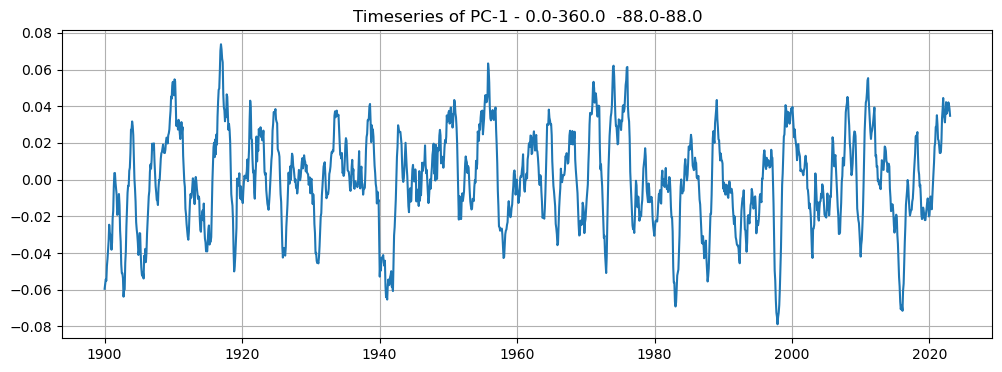

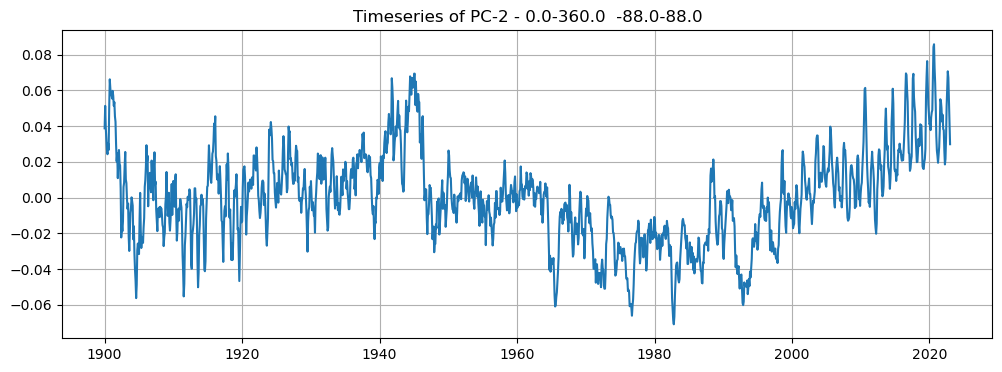

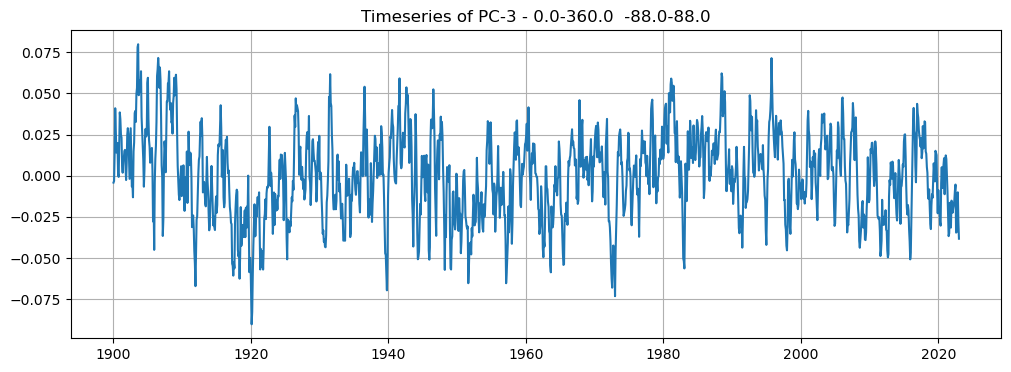

In [580]:
print('u shape',np.shape(u))
print('vh shape',np.shape(vh))
print('s shape',np.shape(s))
type(u)
type(vh)
type(s)
spectrum = s*s.T
spectrum = spectrum/sum(spectrum)
plt.figure(figsize=(12, 4), dpi=100)
yerror = spectrum*np.sqrt(2/dof_sst)
index = np.linspace(0,24,25)
    
plt.errorbar(index[0:12],spectrum[0:12],yerror[0:12],capsize=5)
plt.ylabel('Fraction of Variance')
plt.xlabel('EOF number')
plt.title('Eigenvalue Spectrum - ' + str(lon1) + '-' + str(lon2) + '  ' + str(lat2) +'-' \
              + str(lat1)  )       
#  We need to construct the EOF map by regressing the pc onto the original data
pcmx=3  # were going to consider the first 4 eofs

ts = vh[0:pcmx,:]  # hope this is time series of first eof, YES looks right, has autocorrelation

for pci in range(0,pcmx):

    plt.figure(figsize=(12, 4), dpi=100)
    plt.plot(years,ts[pci,:])
    plt.title('Timeseries of PC-' + str(pci+1) +' - ' + str(lon1) + '-' + str(lon2) + '  ' + str(lat2) +'-' \
              + str(lat1)  )
    plt.grid()




In [581]:
# here we attempt the regression:  we need to go back and get the original data
#sstb = sst.sel(time=slice(1950-1-1, 2022-1-1),lon=slice(0., 360.),lat=slice(89, -89.))
regm = np.empty([pcmx+1,latx*lonx])
for pci in range(0,3):
    t=ts[pci,:]
    t = t/np.std(t)  # normalize predictor to have one standard deviation
    sstb = xr.DataArray.to_numpy(sst0)
    sstb=np.reshape(sstb,(mnx,latx*lonx))
    print('shape sstb ',np.shape(sstb))
    reg = np.matmul(t,sstb)/mnx
    print('shape reg ',np.shape(reg))
    #regm[pci,:] = np.reshape(reg,(latx,lonx))
    regm[pci,:] = reg
    print('shape regn ',np.shape(regm))
regm = np.reshape(regm,(pcmx+1,latx,lonx))  # reshape for plotting    
#plt.figure()
#plt.contourf(regm)

shape sstb  (1476, 16020)
shape reg  (16020,)
shape regn  (4, 16020)
shape sstb  (1476, 16020)
shape reg  (16020,)
shape regn  (4, 16020)
shape sstb  (1476, 16020)
shape reg  (16020,)
shape regn  (4, 16020)


## Map some of our regressions

,  rmax  0.9288131243881055  -  0.9288131243881055


/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/disk/eos10/dennis/anaconda3/envs/atms552/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/

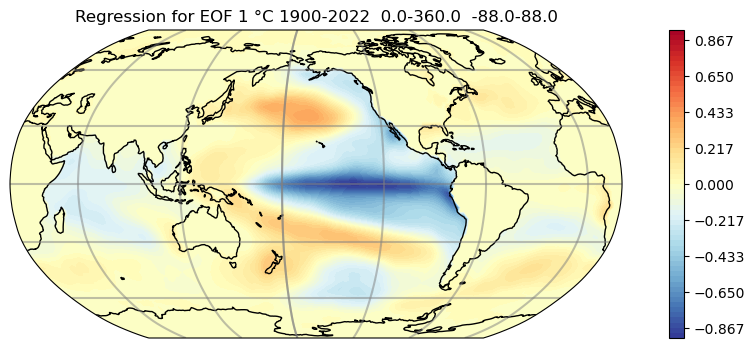

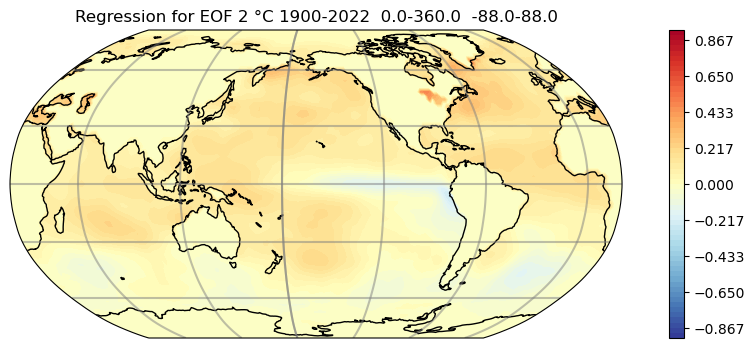

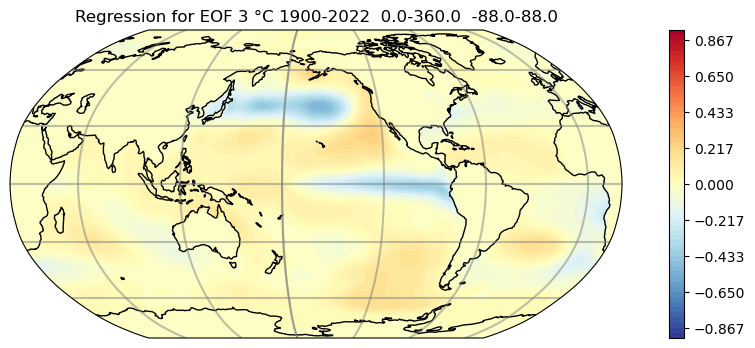

In [582]:
# contour plot some regressions
mnames = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
#col_map = 'coolwarm'
col_mapc = 'RdYlBu_r'
col_mapr = 'RdYlBu_r'
for ip in range(0,pcmx):
    regm1 = regm[ip,:,:]
    # here I am finding the maximum value, then I will fix the contours and colorbar to be constant across months

    if ip == 0:  # same contour interval for all plots
        rmax = np.nanmax(np.abs(regm1))
        nconts=60
        contr = np.linspace(-rmax,rmax,nconts+1)
        print(',  rmax ',rmax, ' - ',np.max(contr))
    plot_regm = True
    if plot_regm:
        # here we extend the array by one, so there is no gap in the contours
        prcpmp = np.empty([latx,lonx+1])  
        prcpm=regm1
        prcpmp[:,0:len(lon)]= prcpm
        prcpmp[:,len(lon+1)]= prcpm[:,0]
        plt.figure(figsize=(12, 4), dpi=100)
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))

        #plt.contourf(lon, lat, rp[i,:,:], contr, cmap=col_mapr,
        plt.contourf(lonp, lat, prcpmp, contr, cmap=col_mapr,
             transform=ccrs.PlateCarree())
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
        ax.coastlines()
        plt.colorbar()
        #plt.clim(contr[0],contr[nconts-1])
        #plt.title('Regression for ' + mnames[i] + ' \N{DEGREE SIGN}C')
        plt.title('Regression for EOF ' + str(ip+1) + ' \N{DEGREE SIGN}C ' + str(yra) + '-' + str(yrb) + '  ' + str(lon1) + '-' + str(lon2) + '  ' + str(lat2) +'-' \
              + str(lat1) )
        #plt.colorbar(location='bottom')
        plt.show()

   
